# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [195]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [196]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

## Análise e visualização de ativos

### Carrega Dados

In [197]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3518, 4)

<Axes: ylabel='Date'>

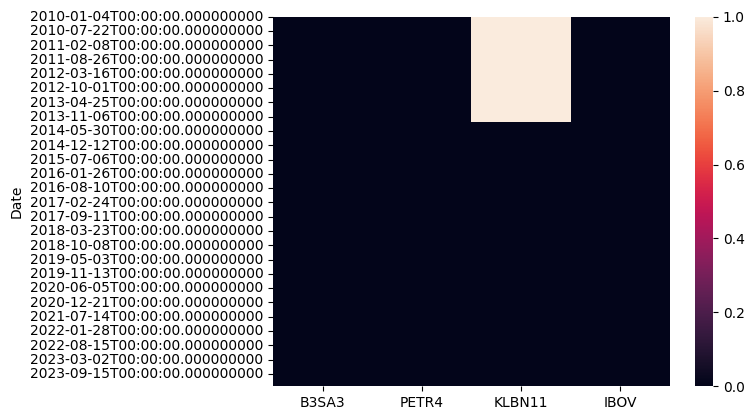

In [198]:
sns.heatmap(acoes_df.isnull())

In [199]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,3.250000,15.470000,11.744000,48321.0
2014-01-24,3.233333,15.100000,11.744000,47787.0
2014-01-27,3.300000,15.110000,11.744000,47701.0
2014-01-28,3.280000,15.050000,12.586000,47841.0
2014-01-29,3.170000,14.800000,12.350000,47557.0
...,...,...,...,...
2024-03-04,12.300000,40.080002,22.510000,128341.0
2024-03-05,12.190000,39.959999,22.299999,128098.0
2024-03-06,12.250000,40.840000,22.150000,128890.0


### Visualização dos dados 

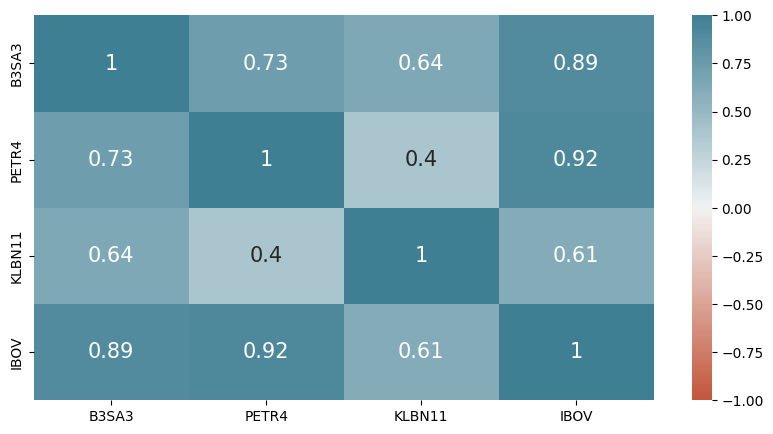

In [200]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [201]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [202]:
acoes_df_normalized

,B3SA3,PETR4,KLBN11,IBOV
Date,,,,
2014-01-23,1.000000,1.000000,1.000000,1.000000
2014-01-24,0.994872,0.976083,1.000000,0.988949
2014-01-27,1.015385,0.976729,1.000000,0.987169
2014-01-28,1.009231,0.972851,1.071696,0.990066
2014-01-29,0.975385,0.956690,1.051601,0.984189
...,...,...,...,...
2024-03-04,3.784615,2.590821,1.916723,2.656009
2024-03-05,3.750769,2.583064,1.898842,2.650980
2024-03-06,3.769231,2.639948,1.886069,2.667370


In [203]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [204]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [205]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [206]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [207]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [208]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()

# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [209]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [210]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [211]:
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variacao'] = ((df['Close'].shift(-7) - df['Close']) / df['Close'])*100

# Definir a variável alvo com base na variação percentual
df['Subida'] = df['Variacao'].apply(lambda x: 1 if x > 1 else 0)

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,EMA200,RSI_14,MACD,Signal,Variacao,Subida,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.279344,21734100,0.000000,0.000000,3.170000,...,3.170000,0.000000,0.000000,0.000000,-4.521582,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.217027,34790100,0.000000,0.000000,3.121852,...,3.126450,0.000000,-0.006914,-0.001383,0.108100,0,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.238598,49214700,0.000000,0.000000,3.118360,...,3.122034,0.000000,-0.009858,-0.003078,-1.284795,0,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.327279,24006600,0.000000,0.000000,3.158437,...,3.151123,0.000000,-0.002215,-0.002905,-2.162717,0,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.296121,22967700,0.000000,0.000000,3.168818,...,3.159735,0.000000,0.000343,-0.002256,-6.263043,0,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,2024-03-04,12.420000,12.440000,12.260000,12.300000,12.300000,32530100,13.444275,12.201724,12.590606,...,13.132738,32.061076,-0.260912,-0.250302,0.000000,0,1,4,3,1
2279,2024-03-05,12.390000,12.410000,12.110000,12.190000,12.190000,41616100,13.433454,12.114545,12.510484,...,13.123357,35.744682,-0.278388,-0.255919,0.000000,0,2,5,3,1
2280,2024-03-06,12.280000,12.360000,12.140000,12.250000,12.250000,64366000,13.416493,12.049507,12.458388,...,13.114667,40.178584,-0.284121,-0.261560,0.000000,0,3,6,3,1
2281,2024-03-07,12.240000,12.400000,12.110000,12.320000,12.320000,43360500,13.356955,12.020044,12.430710,...,13.106760,40.969168,-0.279791,-0.265206,0.000000,0,4,7,3,1


## Tratamento de dados para Predição de ativos

### Pré-processamento dos dados para predição 

In [212]:
ticker

'B3SA3.SA'

In [213]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [214]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [215]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
#features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200']
#features_indicators=[]
#features_indicators=['EMA9', 'EMA20']

acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

/tmp/ipykernel_5268/1102800203.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [216]:
def comput_features(data_array, lookback = 1, features_indicators=[]):

    df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    #df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])

    df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df)
    # Calcula as EMAs de 9 e 20 períodos
    df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    df_['EMA200'] = df_['Close'].ewm(span=200).mean()

    # Calculate RSI (14-period)
    df_['RSI_14'] = calculate_rsi(df, window=14)

    # Calculate MACD (12, 26, 9)
    df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)

    
    df_.iloc[:]= np.nan_to_num(df_.values)

    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    for columns in df_.columns:
        df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]

In [217]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        y += [data[['Close']].values[win:win+pred_days]]
    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y=np.vstack(y)
    return X, y

X, y = windowing(df,features_indicators)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2260, 32)
y shape (2260, 1)
Last Date 2024-03-08T00:00:00.000000000


In [218]:
y=scaler.transform(y)

for idx in range(len(features_indicators)+ lookback):
    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [219]:
'''lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        X += [data[win-lookback:win]]
        y += [data[win:win+pred_days]]  
    X=np.vstack(X)
    y=np.array(y)
    return X, y

X, y = windowing(acoes_df_norm['y'].values)
date_time=acoes_df['ds'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y shape",y.shape)
print("Last Date",date_time.values[-1])'''

'lookback = 23  # number of past days used to predict the future value\npred_days = 1  # number of future days to predict\ndef windowing(data):\n    X = []\n    y = []\n    x_time = []\n    for win in np.arange(lookback,len(data),1):\n        X += [data[win-lookback:win]]\n        y += [data[win:win+pred_days]]  \n    X=np.vstack(X)\n    y=np.array(y)\n    return X, y\n\nX, y = windowing(acoes_df_norm[\'y\'].values)\ndate_time=acoes_df[\'ds\'][lookback:]\n#date_time =date_time_old + datetime.timedelta(days=pred_days)\n\nprint("X shape",X.shape)\nprint("y shape",y.shape)\nprint("Last Date",date_time.values[-1])'

In [220]:
# separa os dados em Treino e Teste
def split_data(X,y,date_time,factor=0.70):
    nits=round(len(X)*factor)
    X_train=X[:nits,:]
    nit_test= np.max(X_train.shape) -1
    X_test=X[nit_test:,:]

    y_train=y[:nits]
    y_test =y[nit_test:]
    
    T_train=date_time[:nits]
    T_test =date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [221]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Modelos de rede neural

### CNN_LSTM

In [222]:
X.shape

(2260, 32)

In [223]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 14, 64)            384       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 7, 64)             0         
                                                                 
 flatten_3 (Flatten)         (None, 448)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                14368     
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                          

### MultiLayer Perceptron

In [224]:
model_name= "MLP"
# Camada de entrada
input_data = Input(shape=(X.shape[1],))

dense_output = Dense(64, activation='relu')(input_data)
#dense_output=Dropout(0.2)(dense_output)

dense_output = Dense(128, activation='relu')(dense_output)
dense_output=Dropout(0.2)(dense_output)

#dense_output = Dense(10, activation='relu')(dense_output)
#dense_output=Dropout(0.5)(dense_output)

# Camada de saída
output = Dense(1, activation='linear')(dense_output)


model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name=model_name
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_32 (Dense)            (None, 64)                2112      
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10561 (41.25 KB)
Trainable params: 10561 (41.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (LSTM) 

In [225]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, activation='relu', return_sequences=False)(input_data)
Dropout_output = Dropout(0.2)(lstm_output)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Long Short-Term Memory (GRU) 

In [226]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64, activation='relu')(input_data)
Dropout_output = Dropout(0.2)(GRU_output)
output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM with Attention layer

In [227]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [228]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

x = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_data)
x = Dropout(0.2)(x)
x = Attention(64)(x)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 32, 1)]           0         
                                                                 
 lstm_7 (LSTM)               (None, 32, 64)            16896     
                                                                 
 dropout_19 (Dropout)        (None, 32, 64)            0         
                                                                 
 attention_3 (Attention)     (None, 64)                4225      
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21186 (82.76 KB)
Trainable params: 21186 (82.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Hiperparâmetros para de treinamento

**Metrics and Loss Functions**  

In [229]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [230]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [231]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200
 1/42 [..............................] - ETA: 15s - loss: 1.8191 - NRMSE: -0.3488
Epoch 1: val_loss improved from inf to 0.43304, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 10ms/step - loss: 161.8217 - NRMSE: -3.6883 - val_loss: 0.4330 - val_NRMSE: 0.3681 - lr: 0.0500
Epoch 2/200
 1/42 [..............................] - ETA: 0s - loss: 0.1128 - NRMSE: 0.6641
Epoch 2: val_loss improved from 0.43304 to 0.18259, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0724 - NRMSE: 0.7335 - val_loss: 0.1826 - val_NRMSE: 0.6100 - lr: 0.0500
Epoch 3/200
 1/42 [..............................] - ETA: 0s - loss: 0.0950 - NRMSE: 0.6918
Epoch 3: val_loss did not improve from 0.18259
42/42 [==============================] - 0s 1ms/step - loss: 0.0569 - NRMSE: 0.7641 - val_loss: 0.1890 - val_NRMSE: 0.6020 - lr: 0.0500
Epoch 4/200
 1/42 [..............................] - ETA: 0s - loss: 0.0589 - NRMSE: 0.7573
Epoch 4: val_loss did not improve from 0.18259
42/42 [==============================] - 0s 1ms/step - loss: 0.0515 - NRMSE: 0.7746 - val_loss: 0.1986 - val_NRMSE: 0.5903 - lr: 0.0500
Epoch 5/200
 1/42 [..............................] - ETA: 0s - loss: 0.0429 - NRMSE: 0.7929
Epoch 5: val_loss improved from 0.18259 to 0.17765, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0484 - NRMSE: 0.7817 - val_loss: 0.1776 - val_NRMSE: 0.6163 - lr: 0.0500
Epoch 6/200
 1/42 [..............................] - ETA: 0s - loss: 0.0302 - NRMSE: 0.8263
Epoch 6: val_loss did not improve from 0.17765
42/42 [==============================] - 0s 2ms/step - loss: 0.0465 - NRMSE: 0.7857 - val_loss: 0.2028 - val_NRMSE: 0.5854 - lr: 0.0500
Epoch 7/200
 1/42 [..............................] - ETA: 0s - loss: 0.0381 - NRMSE: 0.8047
Epoch 7: val_loss did not improve from 0.17765
42/42 [==============================] - 0s 2ms/step - loss: 0.0444 - NRMSE: 0.7910 - val_loss: 0.1928 - val_NRMSE: 0.5974 - lr: 0.0500
Epoch 8/200
 1/42 [..............................] - ETA: 0s - loss: 0.0607 - NRMSE: 0.7536
Epoch 8: val_loss improved from 0.17765 to 0.15813, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 9ms/step - loss: 0.0446 - NRMSE: 0.7907 - val_loss: 0.1581 - val_NRMSE: 0.6421 - lr: 0.0500
Epoch 9/200
 1/42 [..............................] - ETA: 0s - loss: 0.0381 - NRMSE: 0.8049
Epoch 9: val_loss did not improve from 0.15813
42/42 [==============================] - 0s 1ms/step - loss: 0.0455 - NRMSE: 0.7883 - val_loss: 0.1849 - val_NRMSE: 0.6072 - lr: 0.0500
Epoch 10/200
 1/42 [..............................] - ETA: 0s - loss: 0.0572 - NRMSE: 0.7608
Epoch 10: val_loss did not improve from 0.15813
42/42 [==============================] - 0s 1ms/step - loss: 0.0443 - NRMSE: 0.7909 - val_loss: 0.1955 - val_NRMSE: 0.5941 - lr: 0.0500
Epoch 11/200
 1/42 [..............................] - ETA: 0s - loss: 0.0471 - NRMSE: 0.7830
Epoch 11: val_loss did not improve from 0.15813
42/42 [==============================] - 0s 1ms/step - loss: 0.0434 - NRMSE: 0.7925 - val_loss: 0.1657 - val_NRMSE: 0.6319 - lr: 0.0500
Epoch 12/200
 1/42 [...............

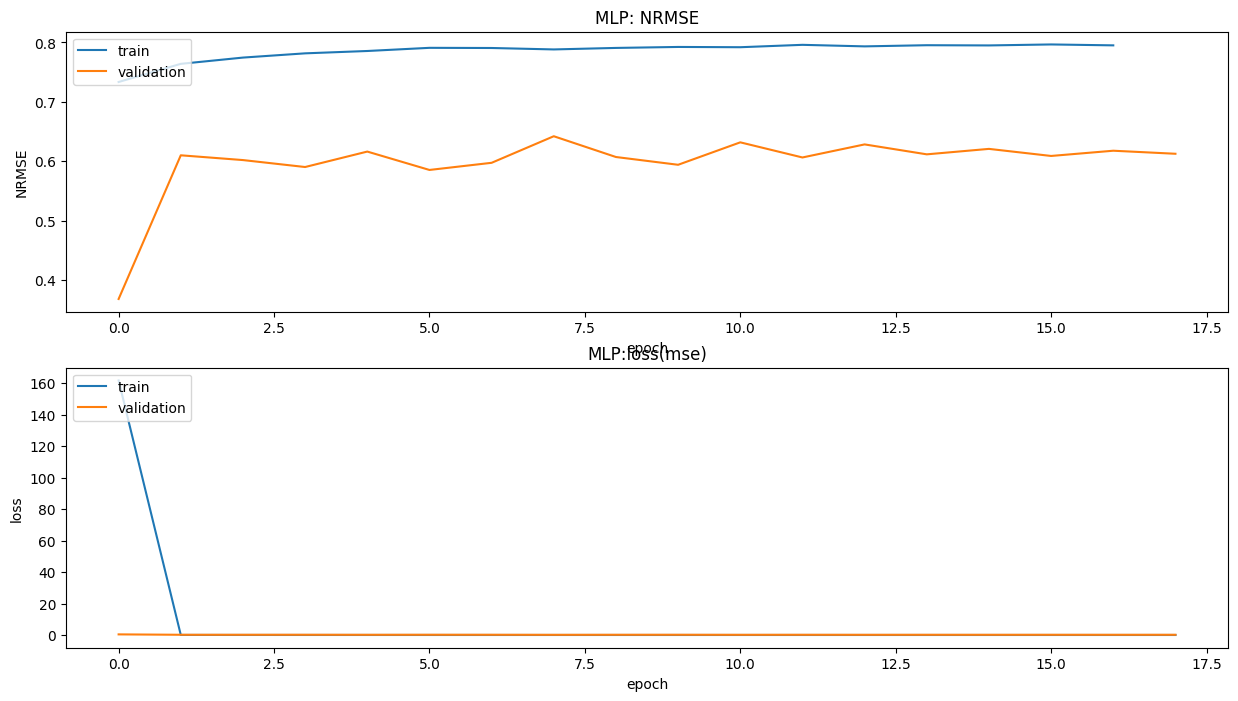

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
36/42 [========================>.....] - ETA: 0s - loss: 2.0415 - NRMSE: 0.5605
Epoch 1: val_loss improved from inf to 0.00846, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 2s 29ms/step - loss: 1.7532 - NRMSE: 0.6021 - val_loss: 0.0085 - val_NRMSE: 0.9173 - lr: 0.0500
Epoch 2/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0151 - NRMSE: 0.8790
Epoch 2: val_loss did not improve from 0.00846
42/42 [==============================] - 0s 5ms/step - loss: 0.0151 - NRMSE: 0.8790 - val_loss: 0.0103 - val_NRMSE: 0.9225 - lr: 0.0500
Epoch 3/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0134 - NRMSE: 0.8870
Epoch 3: val_loss improved from 0.00846 to 0.00772, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 23ms/step - loss: 0.0136 - NRMSE: 0.8861 - val_loss: 0.0077 - val_NRMSE: 0.9190 - lr: 0.0500
Epoch 4/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0097 - NRMSE: 0.9040
Epoch 4: val_loss did not improve from 0.00772
42/42 [==============================] - 0s 5ms/step - loss: 0.0095 - NRMSE: 0.9052 - val_loss: 0.0106 - val_NRMSE: 0.9158 - lr: 0.0500
Epoch 5/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0074 - NRMSE: 0.9159
Epoch 5: val_loss did not improve from 0.00772
42/42 [==============================] - 0s 5ms/step - loss: 0.0073 - NRMSE: 0.9166 - val_loss: 0.0196 - val_NRMSE: 0.8740 - lr: 0.0500
Epoch 6/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9214
Epoch 6: val_loss improved from 0.00772 to 0.00306, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - NRMSE: 0.9226 - val_loss: 0.0031 - val_NRMSE: 0.9533 - lr: 0.0500
Epoch 7/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9348
Epoch 7: val_loss did not improve from 0.00306
42/42 [==============================] - 0s 6ms/step - loss: 0.0048 - NRMSE: 0.9333 - val_loss: 0.0145 - val_NRMSE: 0.8939 - lr: 0.0500
Epoch 8/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9341
Epoch 8: val_loss did not improve from 0.00306
42/42 [==============================] - 0s 5ms/step - loss: 0.0047 - NRMSE: 0.9333 - val_loss: 0.0031 - val_NRMSE: 0.9526 - lr: 0.0500
Epoch 9/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9329
Epoch 9: val_loss improved from 0.00306 to 0.00212, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 24ms/step - loss: 0.0046 - NRMSE: 0.9337 - val_loss: 0.0021 - val_NRMSE: 0.9573 - lr: 0.0500
Epoch 10/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9347
Epoch 10: val_loss did not improve from 0.00212
42/42 [==============================] - 0s 6ms/step - loss: 0.0048 - NRMSE: 0.9340 - val_loss: 0.0068 - val_NRMSE: 0.9240 - lr: 0.0500
Epoch 11/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9363
Epoch 11: val_loss did not improve from 0.00212
42/42 [==============================] - 0s 6ms/step - loss: 0.0042 - NRMSE: 0.9365 - val_loss: 0.0301 - val_NRMSE: 0.8650 - lr: 0.0500
Epoch 12/200
32/42 [=====================>........] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9389
Epoch 12: val_loss did not improve from 0.00212
42/42 [==============================] - 0s 6ms/step - loss: 0.0038 - NRMSE: 0.9399 - val_loss: 0.0077 - val_NRMSE: 0.9304 - lr: 0.0500
Epoch 13/200
37/42 [============

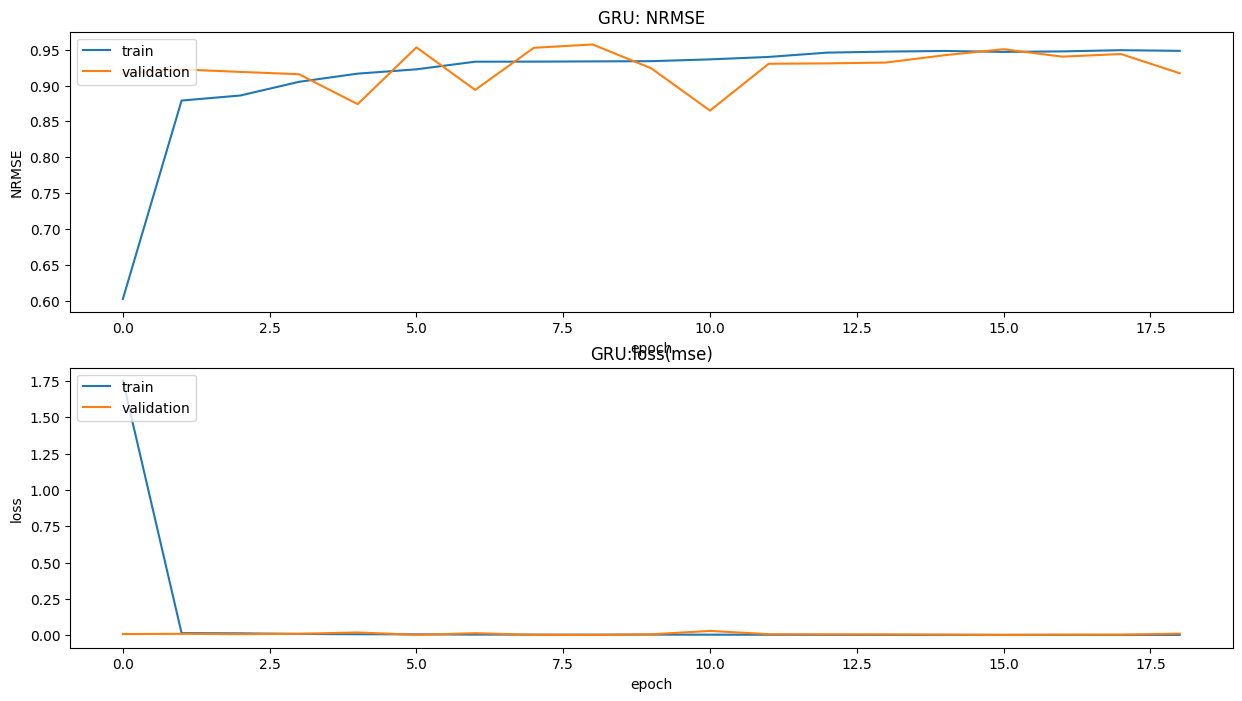

Training model : models/model_CNN_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
 1/42 [..............................] - ETA: 15s - loss: 242.8950 - NRMSE: -14.5851
Epoch 1: val_loss improved from inf to 0.19061, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 12ms/step - loss: 2173.9292 - NRMSE: -8.5169 - val_loss: 0.1906 - val_NRMSE: 0.6001 - lr: 0.0500
Epoch 2/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0409 - NRMSE: 0.7990
Epoch 2: val_loss improved from 0.19061 to 0.18552, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 26ms/step - loss: 0.0399 - NRMSE: 0.8017 - val_loss: 0.1855 - val_NRMSE: 0.6064 - lr: 0.0500
Epoch 3/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0398 - NRMSE: 0.8021
Epoch 3: val_loss improved from 0.18552 to 0.18436, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0398 - NRMSE: 0.8021 - val_loss: 0.1844 - val_NRMSE: 0.6078 - lr: 0.0500
Epoch 4/200
26/42 [=================>............] - ETA: 0s - loss: 0.0406 - NRMSE: 0.7994
Epoch 4: val_loss improved from 0.18436 to 0.18323, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 12ms/step - loss: 0.0397 - NRMSE: 0.8017 - val_loss: 0.1832 - val_NRMSE: 0.6092 - lr: 0.0500
Epoch 5/200
33/42 [======================>.......] - ETA: 0s - loss: 0.0399 - NRMSE: 0.8017
Epoch 5: val_loss improved from 0.18323 to 0.18224, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 12ms/step - loss: 0.0397 - NRMSE: 0.8021 - val_loss: 0.1822 - val_NRMSE: 0.6105 - lr: 0.0500
Epoch 6/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0394 - NRMSE: 0.8033
Epoch 6: val_loss improved from 0.18224 to 0.18110, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0396 - NRMSE: 0.8027 - val_loss: 0.1811 - val_NRMSE: 0.6119 - lr: 0.0500
Epoch 7/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0396 - NRMSE: 0.8026
Epoch 7: val_loss improved from 0.18110 to 0.18008, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0396 - NRMSE: 0.8024 - val_loss: 0.1801 - val_NRMSE: 0.6132 - lr: 0.0500
Epoch 8/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0385 - NRMSE: 0.8055
Epoch 8: val_loss improved from 0.18008 to 0.17905, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0396 - NRMSE: 0.8029 - val_loss: 0.1790 - val_NRMSE: 0.6145 - lr: 0.0500
Epoch 9/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0404 - NRMSE: 0.8007
Epoch 9: val_loss improved from 0.17905 to 0.17800, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0396 - NRMSE: 0.8029 - val_loss: 0.1780 - val_NRMSE: 0.6159 - lr: 0.0500
Epoch 10/200
32/42 [=====================>........] - ETA: 0s - loss: 0.0390 - NRMSE: 0.8039
Epoch 10: val_loss improved from 0.17800 to 0.17728, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1773 - val_NRMSE: 0.6168 - lr: 0.0500
Epoch 11/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0395 - NRMSE: 0.8023
Epoch 11: val_loss improved from 0.17728 to 0.17643, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8022 - val_loss: 0.1764 - val_NRMSE: 0.6179 - lr: 0.0500
Epoch 12/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0392 - NRMSE: 0.8033
Epoch 12: val_loss improved from 0.17643 to 0.17570, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1757 - val_NRMSE: 0.6188 - lr: 0.0500
Epoch 13/200
33/42 [======================>.......] - ETA: 0s - loss: 0.0389 - NRMSE: 0.8039
Epoch 13: val_loss improved from 0.17570 to 0.17506, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8024 - val_loss: 0.1751 - val_NRMSE: 0.6196 - lr: 0.0500
Epoch 14/200
33/42 [======================>.......] - ETA: 0s - loss: 0.0389 - NRMSE: 0.8043
Epoch 14: val_loss improved from 0.17506 to 0.17454, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8026 - val_loss: 0.1745 - val_NRMSE: 0.6203 - lr: 0.0500
Epoch 15/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0396 - NRMSE: 0.8026
Epoch 15: val_loss improved from 0.17454 to 0.17430, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 13ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1743 - val_NRMSE: 0.6206 - lr: 0.0500
Epoch 16/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0393 - NRMSE: 0.8027
Epoch 16: val_loss improved from 0.17430 to 0.17375, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8023 - val_loss: 0.1738 - val_NRMSE: 0.6213 - lr: 0.0500
Epoch 17/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0400 - NRMSE: 0.8010
Epoch 17: val_loss improved from 0.17375 to 0.17300, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0395 - NRMSE: 0.8024 - val_loss: 0.1730 - val_NRMSE: 0.6223 - lr: 0.0500
Epoch 18/200
30/42 [====================>.........] - ETA: 0s - loss: 0.0386 - NRMSE: 0.8047
Epoch 18: val_loss did not improve from 0.17300
42/42 [==============================] - 0s 3ms/step - loss: 0.0395 - NRMSE: 0.8027 - val_loss: 0.1732 - val_NRMSE: 0.6221 - lr: 0.0500
Epoch 19/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0379 - NRMSE: 0.8061
Epoch 19: val_loss improved from 0.17300 to 0.17297, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 24ms/step - loss: 0.0395 - NRMSE: 0.8023 - val_loss: 0.1730 - val_NRMSE: 0.6224 - lr: 0.0500
Epoch 20/200
25/42 [================>.............] - ETA: 0s - loss: 0.0400 - NRMSE: 0.8014
Epoch 20: val_loss improved from 0.17297 to 0.17271, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 12ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1727 - val_NRMSE: 0.6227 - lr: 0.0500
Epoch 21/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0397 - NRMSE: 0.8021
Epoch 21: val_loss improved from 0.17271 to 0.17217, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8026 - val_loss: 0.1722 - val_NRMSE: 0.6234 - lr: 0.0500
Epoch 22/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0394 - NRMSE: 0.8024
Epoch 22: val_loss improved from 0.17217 to 0.17186, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8021 - val_loss: 0.1719 - val_NRMSE: 0.6238 - lr: 0.0500
Epoch 23/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0395 - NRMSE: 0.8029
Epoch 23: val_loss did not improve from 0.17186
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1720 - val_NRMSE: 0.6237 - lr: 0.0500
Epoch 24/200
 1/42 [..............................] - ETA: 0s - loss: 0.0275 - NRMSE: 0.8342
Epoch 24: val_loss improved from 0.17186 to 0.17184, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 13ms/step - loss: 0.0395 - NRMSE: 0.8028 - val_loss: 0.1718 - val_NRMSE: 0.6238 - lr: 0.0500
Epoch 25/200
34/42 [=======================>......] - ETA: 0s - loss: 0.0394 - NRMSE: 0.8031
Epoch 25: val_loss did not improve from 0.17184
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8029 - val_loss: 0.1721 - val_NRMSE: 0.6235 - lr: 0.0500
Epoch 26/200
 1/42 [..............................] - ETA: 0s - loss: 0.0281 - NRMSE: 0.8324
Epoch 26: val_loss did not improve from 0.17184
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8023 - val_loss: 0.1719 - val_NRMSE: 0.6237 - lr: 0.0500
Epoch 27/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0396 - NRMSE: 0.8019
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 27: val_loss did not improve from 0.17184
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8022 - val_l

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8026 - val_loss: 0.1718 - val_NRMSE: 0.6238 - lr: 0.0100
Epoch 29/200
39/42 [==========================>...] - ETA: 0s - loss: 0.0390 - NRMSE: 0.8039
Epoch 29: val_loss did not improve from 0.17182
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8027 - val_loss: 0.1719 - val_NRMSE: 0.6238 - lr: 0.0100
Epoch 30/200
 1/42 [..............................] - ETA: 0s - loss: 0.0328 - NRMSE: 0.8189
Epoch 30: val_loss did not improve from 0.17182
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8026 - val_loss: 0.1719 - val_NRMSE: 0.6238 - lr: 0.0100
Epoch 31/200
 1/42 [..............................] - ETA: 0s - loss: 0.0295 - NRMSE: 0.8283
Epoch 31: val_loss improved from 0.17182 to 0.17177, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 13ms/step - loss: 0.0395 - NRMSE: 0.8022 - val_loss: 0.1718 - val_NRMSE: 0.6239 - lr: 0.0100
Epoch 32/200
31/42 [=====================>........] - ETA: 0s - loss: 0.0410 - NRMSE: 0.7986
Epoch 32: val_loss improved from 0.17177 to 0.17169, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8024 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 0.0100
Epoch 33/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0397 - NRMSE: 0.8022
Epoch 33: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8029 - val_loss: 0.1717 - val_NRMSE: 0.6239 - lr: 0.0100
Epoch 34/200
 1/42 [..............................] - ETA: 0s - loss: 0.0471 - NRMSE: 0.7829
Epoch 34: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8029 - val_loss: 0.1718 - val_NRMSE: 0.6239 - lr: 0.0100
Epoch 35/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0391 - NRMSE: 0.8038
Epoch 35: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8027 - val_loss: 0.1718 - val_NRMSE: 0.6238 - lr: 0.0100
Epoch 36/200
41/42 [============

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8026 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 0.0020
Epoch 43/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0392 - NRMSE: 0.8030
Epoch 43: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8024 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 4.0000e-04
Epoch 44/200
41/42 [============================>.] - ETA: 0s - loss: 0.0393 - NRMSE: 0.8033
Epoch 44: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8030 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 4.0000e-04
Epoch 45/200
32/42 [=====================>........] - ETA: 0s - loss: 0.0392 - NRMSE: 0.8031
Epoch 45: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8025 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 4.0000e-04
Epoch 46/200
37/42 [

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 0s 11ms/step - loss: 0.0395 - NRMSE: 0.8025 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 4.0000e-04
Epoch 47/200
17/42 [===========>..................] - ETA: 0s - loss: 0.0364 - NRMSE: 0.8106
Epoch 47: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.

Epoch 47: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 3ms/step - loss: 0.0395 - NRMSE: 0.8032 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 4.0000e-04
Epoch 48/200
42/42 [==============================] - ETA: 0s - loss: 0.0395 - NRMSE: 0.8024
Epoch 48: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0.8024 - val_loss: 0.1717 - val_NRMSE: 0.6240 - lr: 8.0000e-05
Epoch 49/200
42/42 [==============================] - ETA: 0s - loss: 0.0395 - NRMSE: 0.8026
Epoch 49: val_loss did not improve from 0.17169
42/42 [==============================] - 0s 2ms/step - loss: 0.0395 - NRMSE: 0

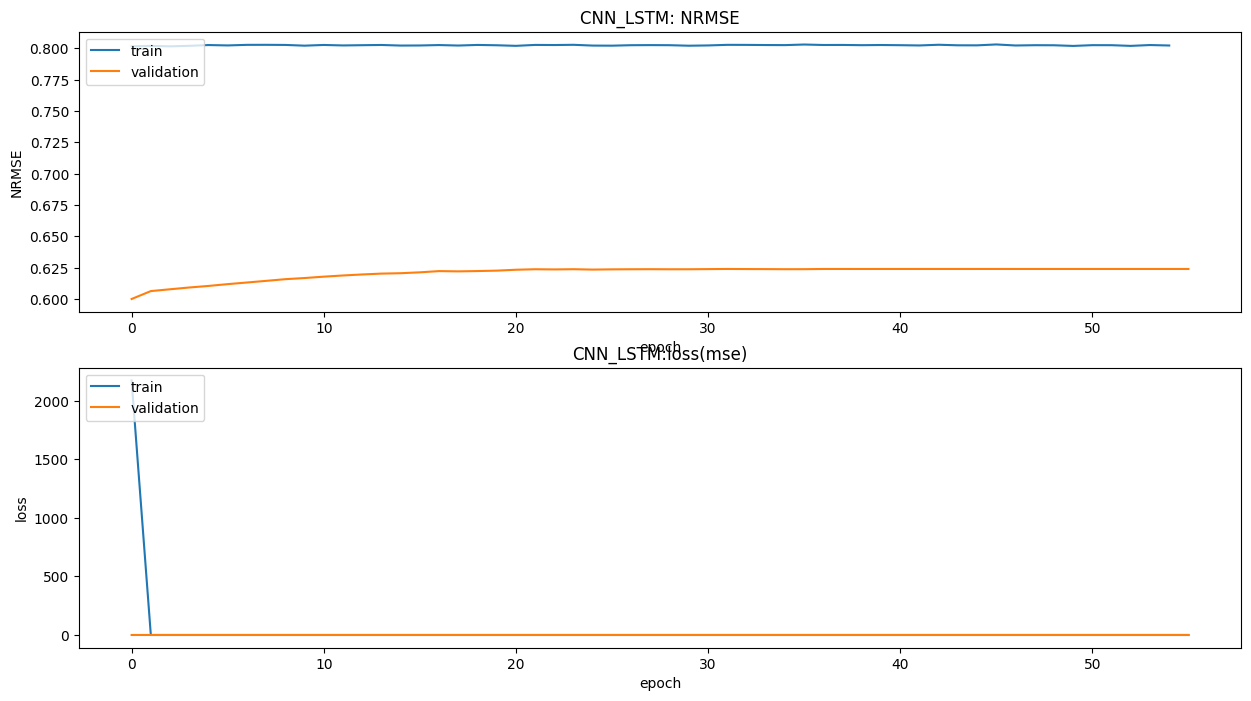

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
35/42 [========================>.....] - ETA: 0s - loss: nan - NRMSE: nan      
Epoch 1: val_loss did not improve from inf
42/42 [==============================] - 1s 10ms/step - loss: nan - NRMSE: nan - val_loss: nan - val_NRMSE: nan - lr: 0.0500
Epoch 2/200
37/42 [=========================>....] - ETA: 0s - loss: nan - NRMSE: nan
Epoch 2: val_loss did not improve from inf
42/42 [==============================] - 0s 8ms/step - loss: nan - NRMSE: nan - val_loss: nan - val_NRMSE: nan - lr: 0.0500
Epoch 3/200
33/42 [======================>.......] - ETA: 0s - loss: nan - NRMSE: nan
Epoch 3: val_loss did not improve from inf
42/42 [==============================] - 0s 6ms/step - loss: nan - NRMSE: nan - val_loss: nan - val_N

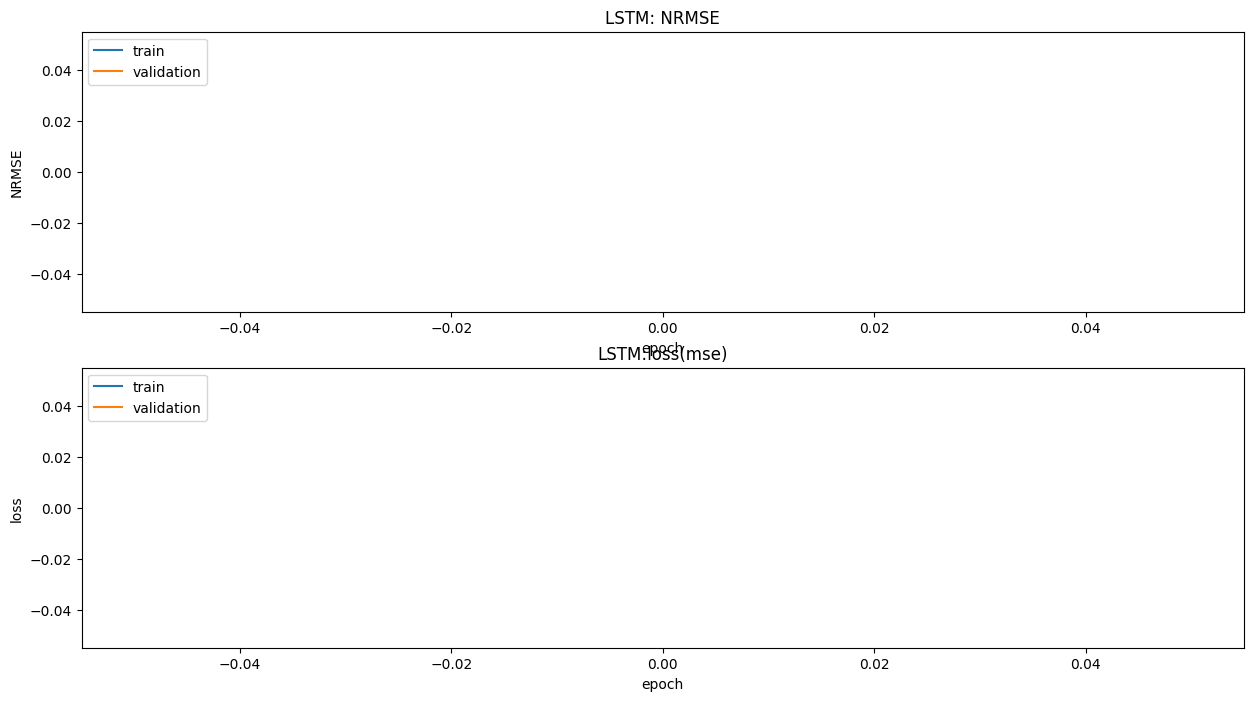

Training model : models/model_LSTM_AT_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
40/42 [===========================>..] - ETA: 0s - loss: 71082623107072.0000 - NRMSE: -1333071.8750
Epoch 1: val_loss improved from inf to 15.61211, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 2s 34ms/step - loss: 67697735892992.0000 - NRMSE: -1269592.2500 - val_loss: 15.6121 - val_NRMSE: -2.9469 - lr: 0.0500
Epoch 2/200
37/42 [=========================>....] - ETA: 0s - loss: 0.4579 - NRMSE: 0.3547
Epoch 2: val_loss improved from 15.61211 to 3.36208, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 2s 45ms/step - loss: 0.4232 - NRMSE: 0.3847 - val_loss: 3.3621 - val_NRMSE: -0.8071 - lr: 0.0500
Epoch 3/200
36/42 [========================>.....] - ETA: 0s - loss: 0.1061 - NRMSE: 0.6797
Epoch 3: val_loss improved from 3.36208 to 2.76567, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 30ms/step - loss: 0.1048 - NRMSE: 0.6825 - val_loss: 2.7657 - val_NRMSE: -0.6396 - lr: 0.0500
Epoch 4/200
34/42 [=======================>......] - ETA: 0s - loss: 0.1030 - NRMSE: 0.6874
Epoch 4: val_loss improved from 2.76567 to 2.64177, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 30ms/step - loss: 0.1028 - NRMSE: 0.6865 - val_loss: 2.6418 - val_NRMSE: -0.6024 - lr: 0.0500
Epoch 5/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0826 - NRMSE: 0.7165
Epoch 5: val_loss improved from 2.64177 to 2.53499, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 29ms/step - loss: 0.0858 - NRMSE: 0.7114 - val_loss: 2.5350 - val_NRMSE: -0.5701 - lr: 0.0500
Epoch 6/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0925 - NRMSE: 0.6994
Epoch 6: val_loss did not improve from 2.53499
42/42 [==============================] - 0s 7ms/step - loss: 0.0902 - NRMSE: 0.7033 - val_loss: 2.6370 - val_NRMSE: -0.6011 - lr: 0.0500
Epoch 7/200
36/42 [========================>.....] - ETA: 0s - loss: 0.0878 - NRMSE: 0.7093
Epoch 7: val_loss did not improve from 2.53499
42/42 [==============================] - 0s 8ms/step - loss: 0.0922 - NRMSE: 0.7024 - val_loss: 2.5968 - val_NRMSE: -0.5888 - lr: 0.0500
Epoch 8/200
37/42 [=========================>....] - ETA: 0s - loss: 0.1121 - NRMSE: 0.6746
Epoch 8: val_loss improved from 2.53499 to 2.50963, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 29ms/step - loss: 0.1075 - NRMSE: 0.6811 - val_loss: 2.5096 - val_NRMSE: -0.5618 - lr: 0.0500
Epoch 9/200
40/42 [===========================>..] - ETA: 0s - loss: 0.0917 - NRMSE: 0.7040
Epoch 9: val_loss did not improve from 2.50963
42/42 [==============================] - 0s 8ms/step - loss: 0.0923 - NRMSE: 0.7030 - val_loss: 2.5503 - val_NRMSE: -0.5742 - lr: 0.0500
Epoch 10/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0884 - NRMSE: 0.7088
Epoch 10: val_loss improved from 2.50963 to 2.49767, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 29ms/step - loss: 0.0884 - NRMSE: 0.7082 - val_loss: 2.4977 - val_NRMSE: -0.5578 - lr: 0.0500
Epoch 11/200
36/42 [========================>.....] - ETA: 0s - loss: 0.1000 - NRMSE: 0.6904
Epoch 11: val_loss improved from 2.49767 to 2.45712, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 30ms/step - loss: 0.1013 - NRMSE: 0.6886 - val_loss: 2.4571 - val_NRMSE: -0.5449 - lr: 0.0500
Epoch 12/200
35/42 [========================>.....] - ETA: 0s - loss: 0.0965 - NRMSE: 0.6966
Epoch 12: val_loss improved from 2.45712 to 2.35895, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


42/42 [==============================] - 1s 32ms/step - loss: 0.0966 - NRMSE: 0.6962 - val_loss: 2.3590 - val_NRMSE: -0.5138 - lr: 0.0500
Epoch 13/200
38/42 [==========================>...] - ETA: 0s - loss: 0.0905 - NRMSE: 0.7054
Epoch 13: val_loss did not improve from 2.35895
42/42 [==============================] - 0s 7ms/step - loss: 0.0897 - NRMSE: 0.7066 - val_loss: 2.4525 - val_NRMSE: -0.5431 - lr: 0.0500
Epoch 14/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0823 - NRMSE: 0.7184
Epoch 14: val_loss did not improve from 2.35895
42/42 [==============================] - 0s 7ms/step - loss: 0.0859 - NRMSE: 0.7129 - val_loss: 2.4264 - val_NRMSE: -0.5348 - lr: 0.0500
Epoch 15/200
37/42 [=========================>....] - ETA: 0s - loss: 0.0869 - NRMSE: 0.7109
Epoch 15: val_loss did not improve from 2.35895
42/42 [==============================] - 0s 7ms/step - loss: 0.0910 - NRMSE: 0.7050 - val_loss: 2.4569 - val_NRMSE: -0.5442 - lr: 0.0500
Epoch 16/200
35/42 [========

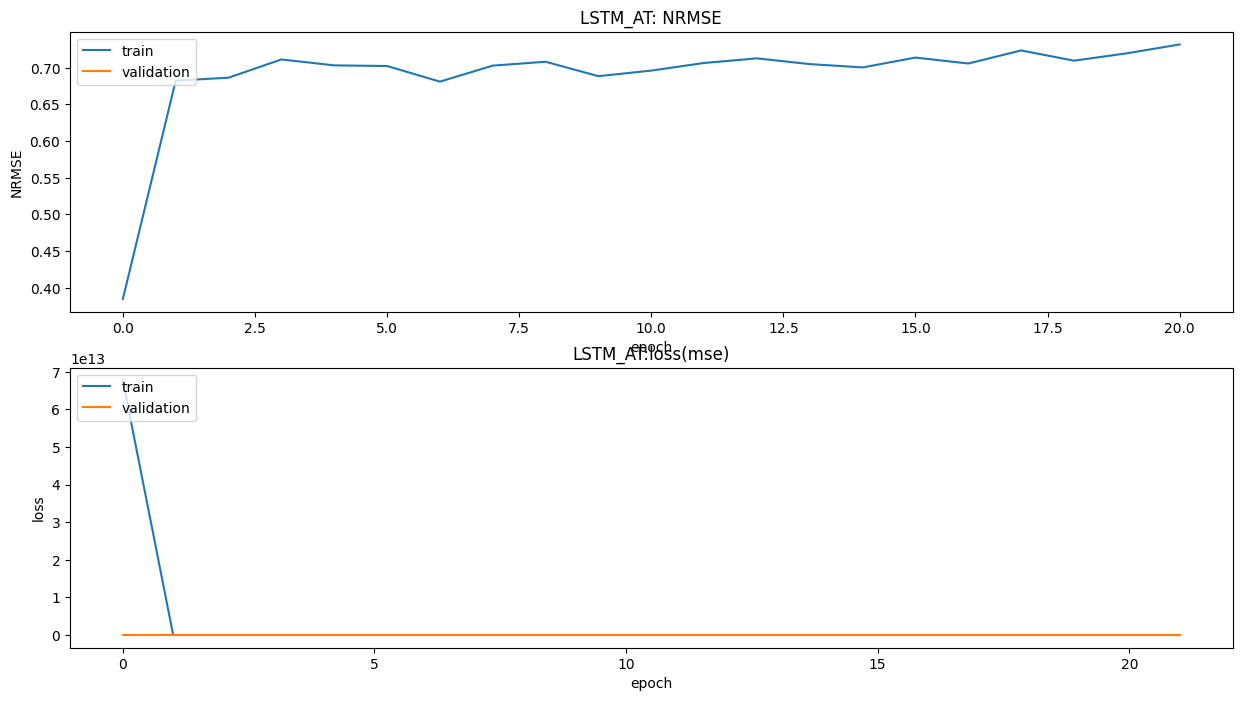

In [232]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validação

In [233]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [234]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [235]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x7f18dcb77880>,
 'GRU': <keras.src.engine.functional.Functional at 0x7f185b544f10>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x7f1959554790>,
 'LSTM': <keras.src.engine.functional.Functional at 0x7f185b5f9420>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x7f18dda6a800>}

In [236]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(acoes_df,features_indicators)

X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

11/11 [==============================] - 0s 711us/step
MLP NN R2: -12.65363493852665
11/11 [==============================] - 0s 4ms/step
GRU NN R2: 0.7740005393836464
11/11 [==============================] - 0s 813us/step
CNN_LSTM NN R2: -14.798265735850435
11/11 [==============================] - 0s 2ms/step
LSTM NN R2: -2618.2542957640217
11/11 [==============================] - 0s 2ms/step
LSTM_AT NN R2: -453.99966843190475


In [237]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [238]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [239]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Geração de valores para predições futuras

In [240]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-03-08
Estamos Fornecendo dados até o dia : 2024-03-07
O modelo fará previsões até o dia:  2024-03-14


In [241]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=2

    if dias_antes == 0:
        NN_predictions=y_test.copy()

        X_inputs=comput_features(y_test,lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(y_test[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    for k in range(n_steps):
        
        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 14ms/step


In [242]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

Using ARIMA model


In [243]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [244]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [245]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

,Data,pred,Variacao,Subida
331,2024-02-27,12.750000,2.117651,1
332,2024-02-28,12.580000,-1.351352,0
333,2024-02-29,12.830000,1.948558,1
334,2024-03-01,12.420000,-3.301126,0
335,2024-03-04,12.300000,-0.975609,0
336,2024-03-05,12.190000,-0.902384,0
337,2024-03-06,12.250000,0.489799,1
338,2024-03-07,12.320000,0.568179,1
339,2024-03-08,8.169181,-50.810708,0
340,2024-03-11,8.169181,0.000000,0


In [246]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

,Data,pred,Variacao,Subida
339,2024-03-08,8.169181,-50.810708,0


In [247]:
result=pred_data_df.iloc[-1:,:]
result

,Data,pred,Variacao,Subida
340,2024-03-11,8.169181,0.0,0


In [248]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-03-11 é de Descida, de 0.0% o valor predito é de: 8.17


In [249]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 15ms/step


array([[8.169181]], dtype=float32)